In [1]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', -1)
from time import time
import re
import string
import os
import emoji
from pprint import pprint
import collections
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib
import gensim
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')
np.random.seed(37)

/Users/yaoqikun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/yaoqikun/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
head = ['sentiment','id','date','query_string','user','text']
df = pd.read_csv('/Users/yaoqikun/Desktop/HKU_Files/MFIN7036/Project/trainingandtestdata/training.csv',names=head)

In [3]:
df.head()

,sentiment,id,date,query_string,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [4]:
df = df.reindex(np.random.permutation(df.index))
df = df[['text', 'sentiment']]

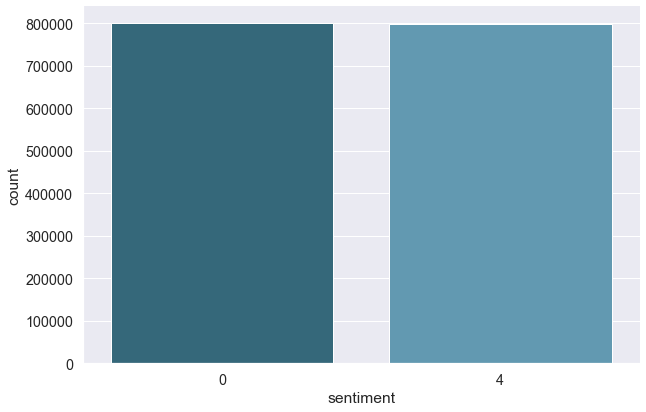

In [8]:
sns.factorplot(x="sentiment", data=df, kind="count", size=6, aspect=1.5, palette="PuBuGn_d")
plt.show();

In [5]:
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used on the train data, but not on the test data
        return self
    
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))
        
        df = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                          })
        
        return df
tc = TextCounts()
df_eda = tc.fit_transform(df.text) #fit_transform(trainData): to find the overall indicators of the part, such as mean, variance, repositioning, etc. (according to the specific conversion purpose), and then transform the trainData to achieve data standardization and normalization, etc
df_eda['sentiment'] = df.sentiment


def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('sentiment')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, col='sentiment', size=5, hue='sentiment', palette="PuBuGn_d")
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()

In [6]:
class CleanText(BaseEstimator, TransformerMixin):
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)
    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
        return clean_X

In [7]:
ct = CleanText()
sr_clean = ct.fit_transform(df.text)
sr_clean.sample(5)

188256     wont let dm ur gonna practic constantli get tablet mail next week lol             
403408     home awesom day paintbal victorio come home find new cat wonder famili            
1122611    retweet lol copi someon say repost peopl see                                      
493379     want flower oh wait got day still nice get no reason anyon want encourag hubbi lol
268594     still shock happen yesterday look forward go cinema marina lt hope destract bit lt
Name: text, dtype: object

In [8]:
empty_clean = sr_clean == ''
print('{} records have no words left after text cleaning'.format(sr_clean[empty_clean].count()))
sr_clean.loc[empty_clean] = '[no_text]'

7305 records have no words left after text cleaning


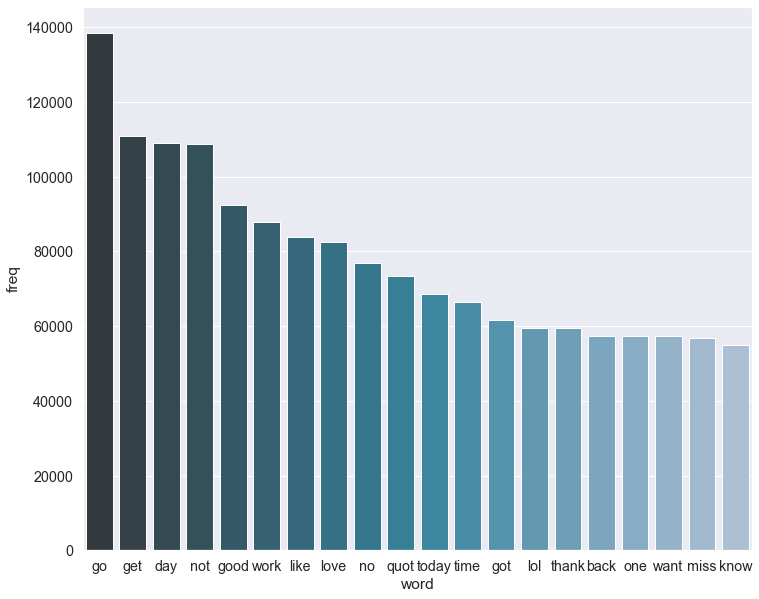

In [24]:
cv = CountVectorizer()
bow = cv.fit_transform(sr_clean)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();

In [9]:
df_model = df_eda
df_model['clean_text'] = sr_clean
df_model.columns.tolist()

['count_words',
 'count_mentions',
 'count_hashtags',
 'count_capital_words',
 'count_excl_quest_marks',
 'count_urls',
 'count_emojis',
 'sentiment',
 'clean_text']

In [10]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols
    def transform(self, X, **transform_params):
        return X[self.cols]
    def fit(self, X, y=None, **fit_params):
        return self
X_train, X_test, y_train, y_test = train_test_split(df_model.drop('sentiment', axis=1), df_model.sentiment, test_size=0.1, random_state=37)

In [11]:
def grid_vect(clf, parameters_clf, X_train, X_test, parameters_text=None, vect=None, is_w2v=False):
    
    textcountscols = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags'
                      ,'count_mentions','count_urls','count_words']
    
    if is_w2v:
        w2vcols = []
        for i in range(SIZE):
            w2vcols.append(i)
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('w2v', ColumnExtractor(cols=w2vcols))]
                                , n_jobs=-1)
    else:
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text')), ('vect', vect)]))]
                                , n_jobs=-1)
    
    pipeline = Pipeline([
        ('features', features)
        , ('clf', clf)
    ])
    
    # Join the parameters dictionaries together
    parameters = dict()
    if parameters_text:
        parameters.update(parameters_text)
    parameters.update(parameters_clf)
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5)
    
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()
    print("Best CV score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_test, y_test))
    print("\n")
    print("Classification Report Test Data")
    print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))
                        
    return grid_search

In [12]:
# Parameter grid settings for the vectorizers (Count and TFIDF)
parameters_vect = {
    'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
    'features__pipe__vect__ngram_range': ((1, 1), (1, 2)),
    'features__pipe__vect__min_df': (1,2)
}

# Parameter grid settings for MultinomialNB
parameters_mnb = {
    'clf__alpha': (0.25, 0.5, 0.75)
}

# Parameter grid settings for LogisticRegression
parameters_logreg = {
    'clf__C': (0.25, 0.5, 1.0),
    'clf__penalty': ('l1', 'l2')
}

In [13]:
mnb = MultinomialNB()
logreg = LogisticRegression()

In [21]:
countvect = CountVectorizer()
# MultinomialNB
best_mnb_countvect = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=countvect)
#joblib.dump(best_mnb_countvect, '../output/best_mnb_countvect.pkl')
# LogisticRegression
#best_logreg_countvect = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=countvect)
#joblib.dump(best_logreg_countvect, '../output/best_logreg_countvect.pkl')

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 46.6min finished


done in 2885.974s

Best CV score: 0.782
Best parameters set:
	clf__alpha: 0.75
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.785


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.79      0.78      0.78     80055
           4       0.78      0.79      0.79     79863

    accuracy                           0.78    159918
   macro avg       0.78      0.78      0.78    159918
weighted avg       0.78      0.78      0.78    159918



FileNotFoundError: [Errno 2] No such file or directory: '../output/best_mnb_countvect.pkl'

In [23]:
joblib.dump(best_mnb_countvect, '/Users/yaoqikun/Desktop/HKU_Files/MFIN7036/Project/output/best_mnb_countvect.pkl')

['/Users/yaoqikun/Desktop/HKU_Files/MFIN7036/Project/output/best_mnb_countvect.pkl']

In [14]:
best_mnb_countvect = joblib.load('/Users/yaoqikun/Desktop/HKU_Files/MFIN7036/Project/output/best_mnb_countvect.pkl')

In [22]:
best_logreg_countvect = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=countvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0),
 'clf__penalty': ('l1', 'l2'),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 70.8min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 140.8min finished


done in 8686.795s

Best CV score: 0.783
Best parameters set:
	clf__C: 1.0
	clf__penalty: 'l2'
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.785


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.80      0.75      0.78     80055
           4       0.77      0.82      0.79     79863

    accuracy                           0.79    159918
   macro avg       0.79      0.79      0.79    159918
weighted avg       0.79      0.79      0.79    159918



In [24]:
joblib.dump(best_logreg_countvect, '/Users/yaoqikun/Desktop/HKU_Files/MFIN7036/Project/output/best_logreg_countvect.pkl')

['/Users/yaoqikun/Desktop/HKU_Files/MFIN7036/Project/output/best_logreg_countvect.pkl']

In [15]:
best_logreg_countvect = joblib.load('/Users/yaoqikun/Desktop/HKU_Files/MFIN7036/Project/output/best_logreg_countvect.pkl')

In [17]:
tfidfvect = TfidfVectorizer()

In [25]:
tfidfvect = TfidfVectorizer()
# MultinomialNB
best_mnb_tfidf = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)
joblib.dump(best_mnb_tfidf, '/Users/yaoqikun/Desktop/HKU_Files/MFIN7036/Project/output/best_mnb_tfidf.pkl')
# LogisticRegression
#best_logreg_tfidf = grid_vect(logreg, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)
#joblib.dump(best_logreg_tfidf, '/Users/yaoqikun/Desktop/HKU_Files/MFIN7036/Project/output/best_logreg_tfidf.pkl')

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 48.9min finished


done in 3028.078s

Best CV score: 0.776
Best parameters set:
	clf__alpha: 0.75
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.777


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.77      0.79      0.78     80055
           4       0.78      0.77      0.78     79863

    accuracy                           0.78    159918
   macro avg       0.78      0.78      0.78    159918
weighted avg       0.78      0.78      0.78    159918

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


ValueError: Invalid parameter alpha for estimator LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False). Check the list of available parameters with `estimator.get_params().keys()`.

In [31]:
best_mnb_tfidf = joblib.load('/Users/yaoqikun/Desktop/HKU_Files/MFIN7036/Project/output/best_mnb_tfidf.pkl')

In [22]:
# LogisticRegression
best_logreg_tfidf = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)
joblib.dump(best_logreg_tfidf, '/Users/yaoqikun/Desktop/HKU_Files/MFIN7036/Project/output/best_logreg_tfidf.pkl')

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0),
 'clf__penalty': ('l1', 'l2'),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 90.9min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 160.6min finished


done in 9771.205s

Best CV score: 0.768
Best parameters set:
	clf__C: 0.5
	clf__penalty: 'l2'
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.775


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.78      0.77      0.77     80055
           4       0.77      0.78      0.78     79863

    accuracy                           0.78    159918
   macro avg       0.78      0.78      0.78    159918
weighted avg       0.78      0.78      0.78    159918



['/Users/yaoqikun/Desktop/HKU_Files/MFIN7036/Project/output/best_logreg_tfidf.pkl']

In [25]:
SIZE = 50
X_train['clean_text_wordlist'] = X_train.clean_text.apply(lambda x : word_tokenize(x))
X_test['clean_text_wordlist'] = X_test.clean_text.apply(lambda x : word_tokenize(x))
model = gensim.models.Word2Vec(X_train.clean_text_wordlist
, min_count=1
, size=SIZE
, window=5
, workers=4)

In [57]:
model.most_similar('stock', topn=3)

[('purchas', 0.8673825860023499),
 ('item', 0.8280295133590698),
 ('ebay', 0.8259541988372803)]

In [26]:
def compute_avg_w2v_vector(w2v_dict, tweet):
    list_of_word_vectors = [w2v_dict[w] for w in tweet if w in w2v_dict.vocab.keys()]
    
    if len(list_of_word_vectors) == 0:
        result = [0.0]*SIZE
    else:
        result = np.sum(list_of_word_vectors, axis=0) / len(list_of_word_vectors)
        
    return result
X_train_w2v = X_train['clean_text_wordlist'].apply(lambda x: compute_avg_w2v_vector(model.wv, x))
X_test_w2v = X_test['clean_text_wordlist'].apply(lambda x: compute_avg_w2v_vector(model.wv, x))

In [27]:
X_train_w2v = pd.DataFrame(X_train_w2v.values.tolist(), index= X_train.index)
X_test_w2v = pd.DataFrame(X_test_w2v.values.tolist(), index= X_test.index)
# Concatenate with the TextCounts variables
X_train_w2v = pd.concat([X_train_w2v, X_train.drop(['clean_text', 'clean_text_wordlist'], axis=1)], axis=1)
X_test_w2v = pd.concat([X_test_w2v, X_test.drop(['clean_text', 'clean_text_wordlist'], axis=1)], axis=1)

In [60]:
best_logreg_w2v = grid_vect(logreg, parameters_logreg, X_train_w2v, X_test_w2v, is_w2v=True)
joblib.dump(best_logreg_w2v, '/Users/yaoqikun/Desktop/HKU_Files/MFIN7036/Project/output/best_logreg_w2v.pkl')

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0), 'clf__penalty': ('l1', 'l2')}
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.2min finished


done in 275.934s

Best CV score: 0.748
Best parameters set:
	clf__C: 0.5
	clf__penalty: 'l2'
Test score with best_estimator_: 0.748


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.75      0.75      0.75     80055
           4       0.75      0.75      0.75     79863

    accuracy                           0.75    159918
   macro avg       0.75      0.75      0.75    159918
weighted avg       0.75      0.75      0.75    159918



['/Users/yaoqikun/Desktop/HKU_Files/MFIN7036/Project/output/best_logreg_w2v.pkl']

In [43]:
best_logreg_w2v = joblib.load('/Users/yaoqikun/Desktop/HKU_Files/MFIN7036/Project/output/best_logreg_w2v.pkl')

In [32]:
textcountscols = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags'
,'count_mentions','count_urls','count_words']
features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
, ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text'))
, ('vect', CountVectorizer(max_df=0.5, min_df=1, ngram_range=(1,2)))]))]
, n_jobs=-1)
pipeline = Pipeline([
('features', features)
, ('clf', LogisticRegression(C=1.0, penalty='l2'))
])
best_model = pipeline.fit(df_model.drop('sentiment', axis=1), df_model.sentiment)

In [31]:
best_model = joblib.load('/Users/yaoqikun/Desktop/HKU_Files/MFIN7036/Project/output/best_model.pkl')

In [34]:
joblib.dump(best_model, '/Users/yaoqikun/Desktop/HKU_Files/MFIN7036/Project/output/best_model_new.pkl')

['/Users/yaoqikun/Desktop/HKU_Files/MFIN7036/Project/output/best_model_new.pkl']

In [33]:
import csv
data_sorted = pd.read_csv('/Users/yaoqikun/Desktop/HKU_Files/MFIN7036/Project/sorted_new_remove_language.csv')
texts_pred = data_sorted.content
new_tweets = pd.Series(texts_pred)
df_counts_pred = tc.transform(new_tweets)
df_clean_pred = ct.transform(new_tweets)
df_model_pred = df_counts_pred
df_model_pred['clean_text'] = df_clean_pred
results=best_model.predict(df_model_pred).tolist()

In [35]:
print(results)

[0, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 4, 0, 4, 4, 0, 4, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 4, 0, 4, 0, 0, 0, 4, 0, 4, 4, 4, 4, 0, 4, 0, 4, 0, 4, 4, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 4, 4, 4, 0, 0, 4, 0, 4, 4, 0, 4, 0, 0, 0, 4, 0, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 0, 4, 0, 0, 4, 0, 4, 4, 4, 4, 4, 0, 4, 0, 4, 0, 0, 4, 0, 0, 0, 4, 4, 0, 0, 4, 4, 0, 0, 4, 0, 0, 0, 4, 0, 4, 0, 4, 0, 4, 4, 4, 4, 4, 4, 0, 0, 4, 4, 4, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 4, 4, 0, 4, 0, 0, 0, 0, 4, 4, 4, 4, 0, 0, 0, 4, 0, 0, 4, 0, 4, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 4, 4, 0, 4, 0, 4, 0, 4, 4, 4, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 4, 0, 4, 0, 4, 0, 4, 4, 4, 4, 0, 4, 0, 0, 4, 0, 0, 4, 0, 4, 0, 4, 4, 0, 0, 4, 0, 0, 4, 0, 0, 4, 4, 0, 0, 0, 0, 0, 4, 4, 4, 0, 4, 0, 0, 0, 4, 0, 4, 4, 4, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 4, 0, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 0, 0, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 0, 0, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 4, 0, 

In [36]:
len(results)

28823

In [37]:
data_sorted['sentiment']=results

In [38]:
data_sorted.to_csv('sorted_new_remove_language_sentiment_newmodel.csv')

In [39]:
data_sorted.loc[:,'sentiment'].value_counts()

0    15778
4    13045
Name: sentiment, dtype: int64